# 数据背景
本次数据来自于2019未来杯高校AI挑战赛中的[城市-房产租金预测](https://2019ai.futurelab.tv/contest_detail/3#contest_des)，赛题要求是根据提供的数据预测特定条件下房屋的房租

In [8]:
# 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# 导入数据
data_train = pd.read_csv('train_data.csv')
data_test = pd.read_csv('test_a.csv')
# 合并数据
data_all = pd.concat([data_train, data_test])
# 预览数据
data_all.head(10)

,ID,area,bankNum,buildYear,busStationNum,city,communityName,drugStoreNum,gymNum,hospitalNum,...,totalWorkers,tradeLandArea,tradeLandNum,tradeMeanPrice,tradeMoney,tradeNewMeanPrice,tradeNewNum,tradeSecNum,tradeTime,uv
0,100309852,68.06,16,1953,36,SH,XQ00051,12,15,1,...,28248,0.0,0,47974.22551,2000.0,104573.48460,25,111,2018/11/28,284.0
1,100307942,125.55,16,2007,184,SH,XQ00130,27,5,1,...,14823,0.0,0,40706.66775,2000.0,33807.53497,2,2,2018/12/16,22.0
2,100307764,132.00,37,暂无信息,60,SH,XQ00179,24,35,3,...,77645,0.0,0,34384.35089,16000.0,109734.16040,11,555,2018/12/22,20.0
3,100306518,57.00,47,暂无信息,364,SH,XQ00313,83,30,8,...,8750,108037.8,1,20529.55050,1600.0,30587.07058,58,260,2018/12/21,279.0
4,100305262,129.00,10,暂无信息,141,SH,XQ01257,21,5,0,...,800,0.0,0,24386.36577,2900.0,51127.32846,34,38,2018/11/18,480.0
5,100304268,223.35,95,2003,276,SH,XQ00457,118,64,14,...,48204,0.0,0,41847.05870,14000.0,82388.42970,146,276,2018/11/14,1304.0
6,100304055,78.94,47,2014,364,SH,XQ00246,83,30,8,...,8750,0.0,0,20106.77761,1000.0,29691.24733,46,216,2018/11/18,469.0
7,100295123,76.00,86,1997,461,SH,XQ02331,106,36,6,...,28546,0.0,0,22759.44425,1800.0,35584.24959,389,481,2018/3/24,2942.0
8,100293141,120.55,86,2007,461,SH,XQ02346,106,36,6,...,28546,0.0,0,22759.44425,1450.0,35584.24959,389,481,2018/3/19,2942.0
9,100293063,83.00,86,1993,461,SH,XQ02310,106,36,6,...,28546,0.0,0,21067.22902,1700.0,33797.35915,119,331,2018/4/26,3035.0


## 数据概览
* 1.数据属性
* 2.数据规模
* 3.数据预处理

In [6]:
# 训练集
print('训练集数值变量描述统计：',data_train.describe())
print('训练集数据大小：',len(data_train))
# 测试集
print('--------------')
print('测试集数值变量描述统计：',data_test.describe())
print('测试集数据大小：',len(data_test))

训练集数值变量描述统计：                  ID          area    totalFloor  saleSecHouseNum  \
count  4.144000e+04  41440.000000  41440.000000     41440.000000   
mean   1.001221e+08     70.959409     11.413152         1.338538   
std    9.376566e+04     88.119569      7.375203         3.180349   
min    1.000000e+08      1.000000      0.000000         0.000000   
25%    1.000470e+08     42.607500      6.000000         0.000000   
50%    1.000960e+08     65.000000      7.000000         0.000000   
75%    1.001902e+08     90.000000     16.000000         1.000000   
max    1.003218e+08  15055.000000     88.000000        52.000000   

       subwayStationNum  busStationNum  interSchoolNum     schoolNum  \
count      41440.000000   41440.000000    41440.000000  41440.000000   
mean           5.741192     187.197153        1.506395     48.228813   
std            4.604929     179.674625        1.687631     29.568448   
min            0.000000      24.000000        0.000000      9.000000   
25%           

结合所有数据的初步分析可知，数据共有51个变量，训练集41440条，测试集2469条，其中分类变量11个，数值变量40个，当然其中有部分变量误归纳为数值变量或分类变量，如ID、buildYear，这类变量不存在任何分析价值或需要进一步处理。目标变量tradeMoney为数值变量，表明这是一个预测问题。除此之外，对于数据的描述统计不难得出，大部分变量并不符合正态分布，存在较大的异常值，这对于回归预测则需要对数据做更多处理。

pv              20
uv              20
tradeMoney    2469
dtype: int64 
 pv            0.000455
uv            0.000455
tradeMoney    0.056230
dtype: float64


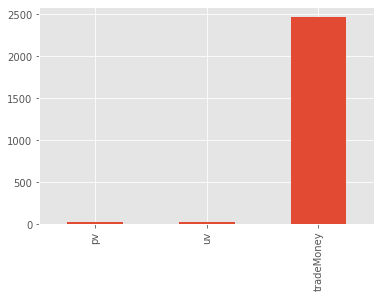

In [55]:
# 缺失值处理（数据为空值）
plt.style.use("ggplot")
missing = data_all.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
missing_perc = missing / len(data_all)
print(missing,'\n', missing_perc)

数据集中仅pv、uv变量存在缺失值，仅有20条，占所有数据的0.045%。而缺失的tradeMoney来自于没有的测试集数据。

## 特征分析
* 1.目标变量
* 2.数值变量
* 3.分类变量


count    4.144000e+04
mean     8.837074e+03
std      5.514287e+05
min      0.000000e+00
25%      2.800000e+03
50%      4.000000e+03
75%      5.500000e+03
max      1.000000e+08
Name: tradeMoney, dtype: float64


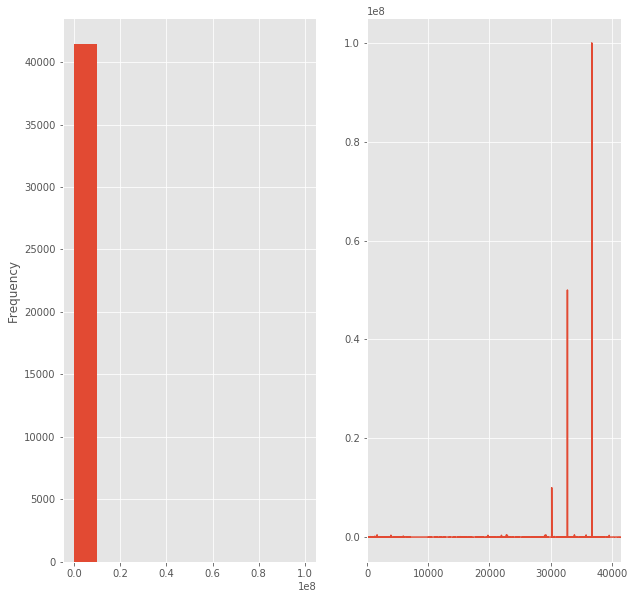

In [67]:
# 目标变量tradeMoney
print(data_train['tradeMoney'].describe())
fig,axes = plt.subplots(1,2,figsize = (10,10))
data_train['tradeMoney'].plot(kind = 'hist',ax = axes[0])
data_train['tradeMoney'].plot(kind = 'line', ax= axes[1])

由上可知，目标变量存在一些离群点，且不服从正态分布，应需要作数据变换处理。

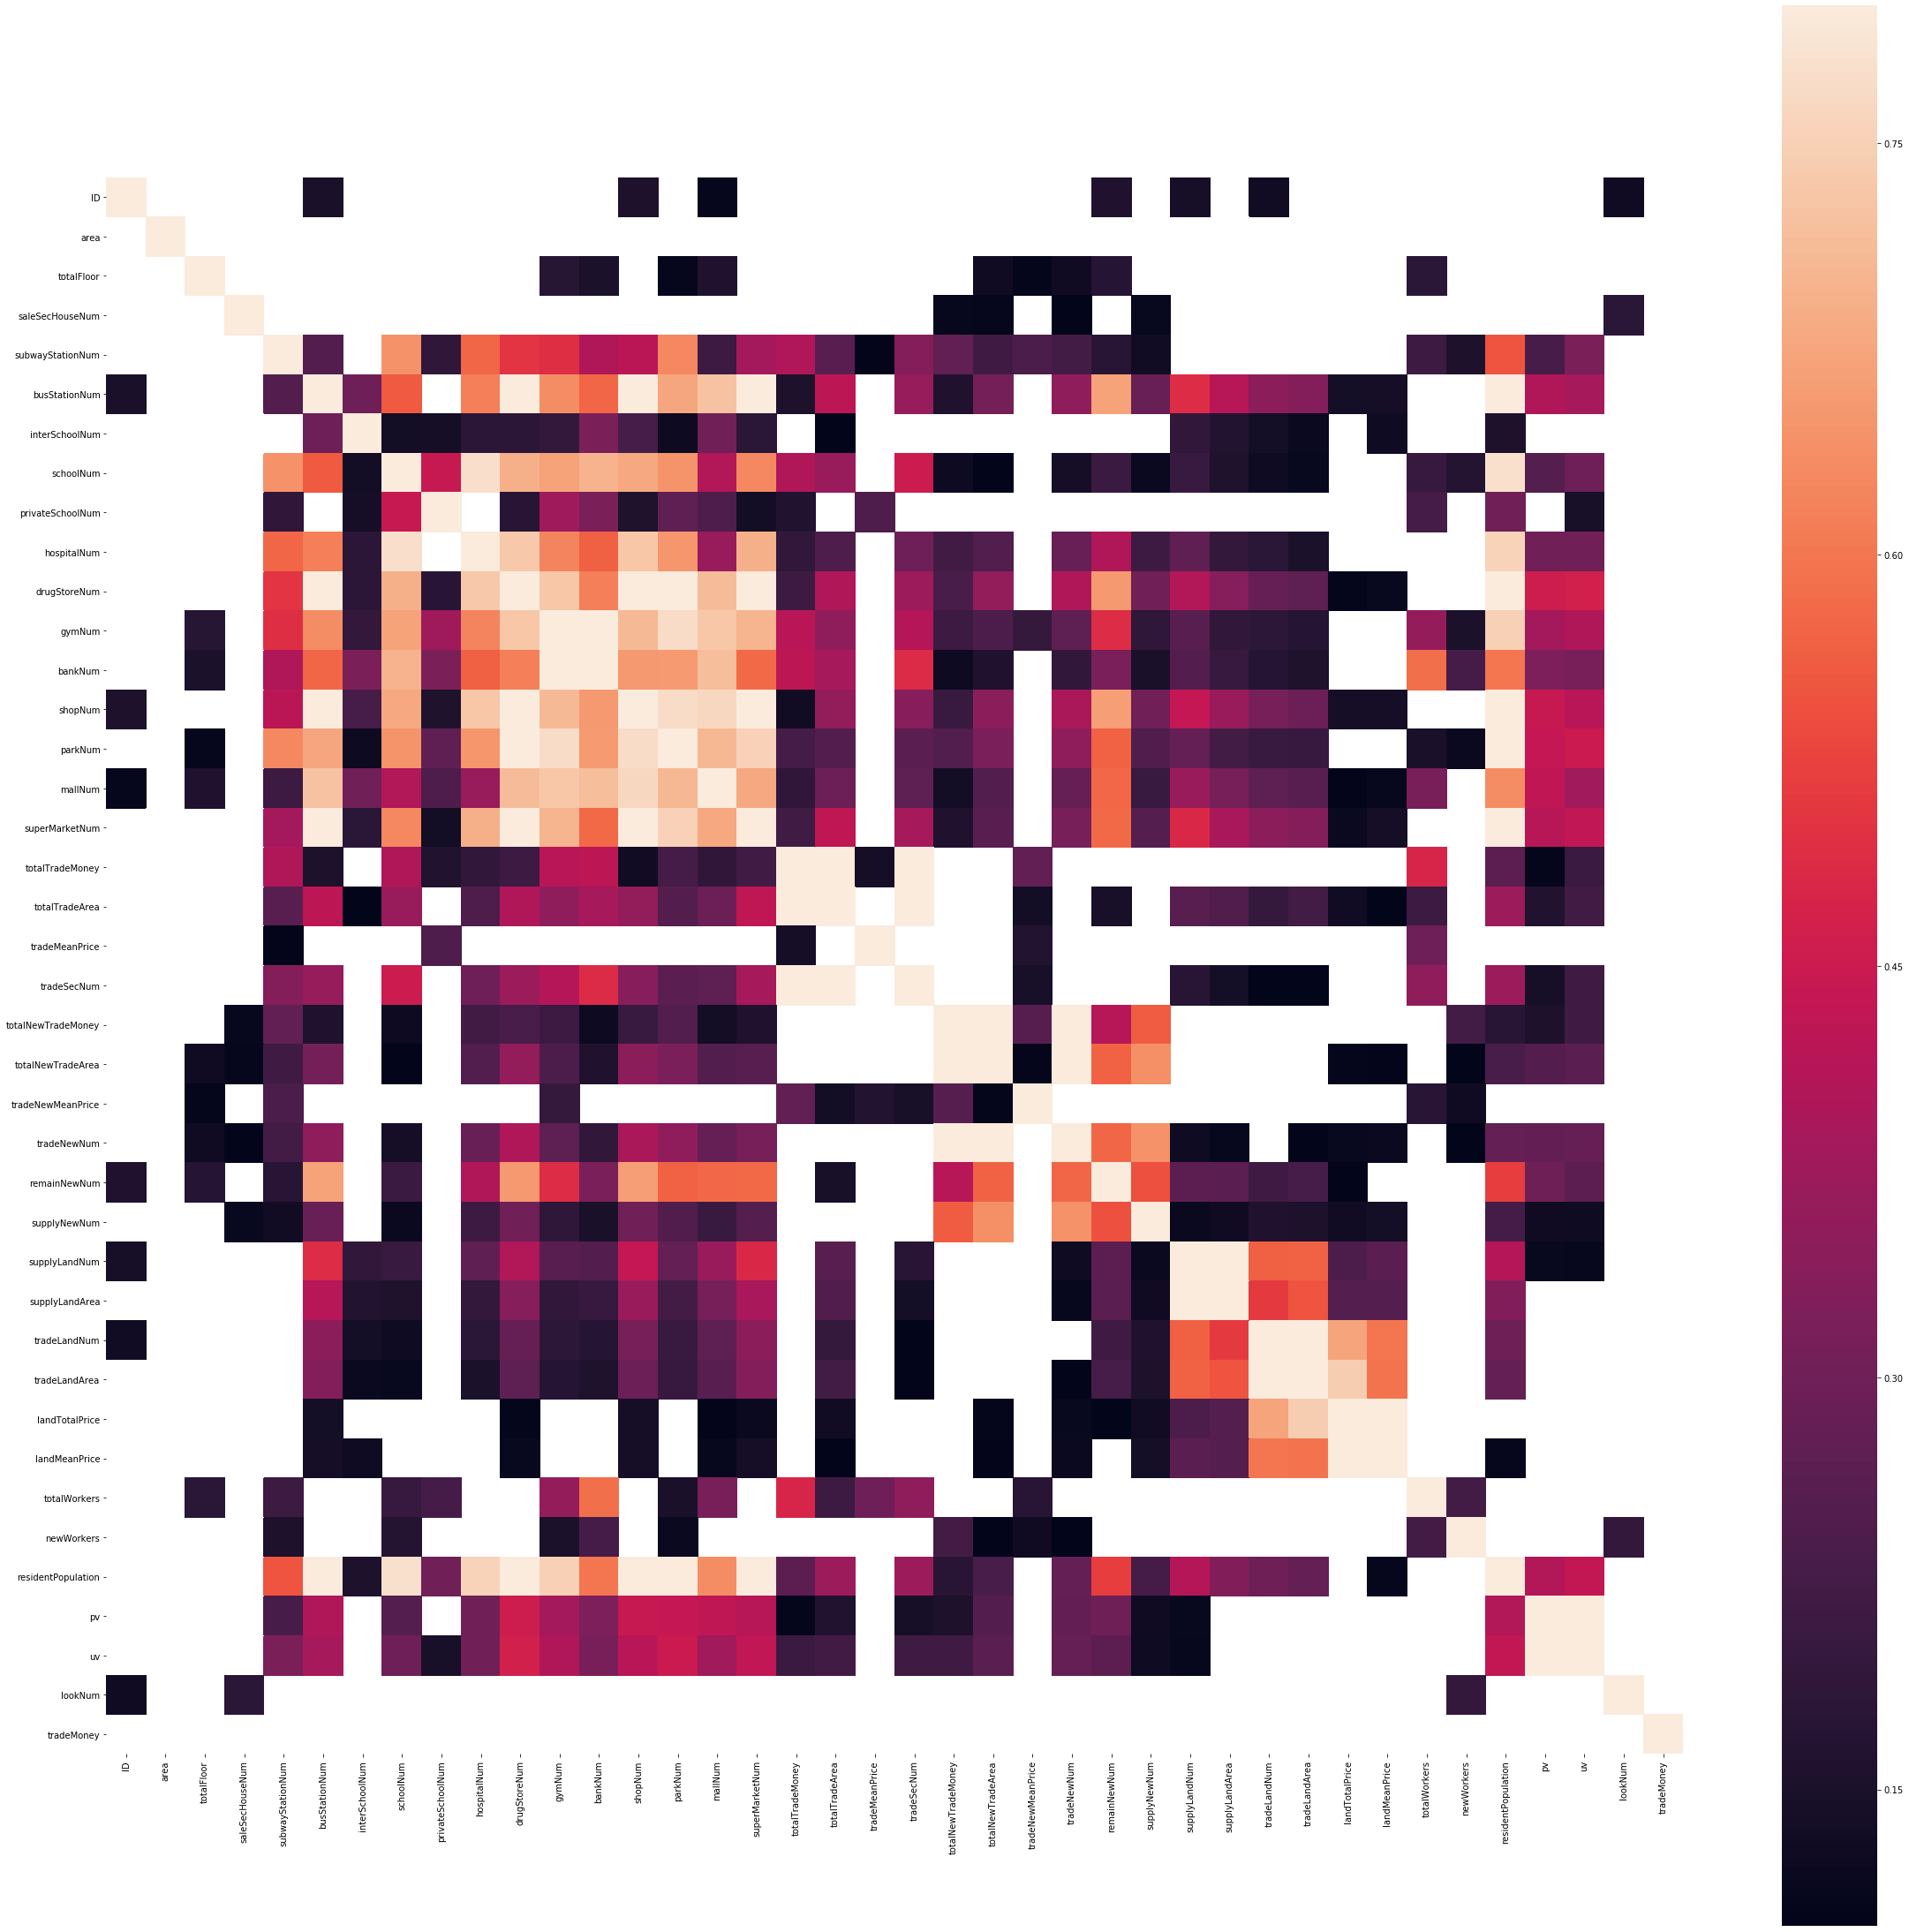

In [9]:
# 数值变量
corrmat = data_train.corr()
corrmat = corrmat[corrmat > 0.1]
f, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(corrmat, vmax=.8, square=True);

In [12]:
corrmat

,ID,area,totalFloor,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney
ID,1.000000,NaN,NaN,NaN,NaN,0.149062,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.127877,NaN
area,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalFloor,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.178294,NaN,NaN,NaN,NaN,NaN,NaN
saleSecHouseNum,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177540,NaN
subwayStationNum,NaN,NaN,NaN,NaN,1.000000,0.252314,NaN,0.643900,0.188826,0.573360,...,NaN,NaN,NaN,0.212760,0.154487,0.549301,0.233920,0.319362,NaN,NaN
busStationNum,0.149062,NaN,NaN,NaN,0.252314,1.000000,0.297939,0.558335,NaN,0.613182,...,0.334577,0.137075,0.138972,NaN,NaN,0.845071,0.405936,0.389930,NaN,NaN
interSchoolNum,NaN,NaN,NaN,NaN,NaN,0.297939,1.000000,0.133932,0.139548,0.181332,...,0.121680,NaN,0.125085,NaN,NaN,0.153226,NaN,NaN,NaN,NaN
schoolNum,NaN,NaN,NaN,NaN,0.643900,0.558335,0.133932,1.000000,0.443438,0.775448,...,0.116114,NaN,NaN,0.202449,0.167598,0.780225,0.254587,0.298972,NaN,NaN
privateSchoolNum,NaN,NaN,NaN,NaN,0.188826,NaN,0.139548,0.443438,1.000000,NaN,...,NaN,NaN,NaN,0.227847,NaN,0.300599,NaN,0.145441,NaN,NaN
hospitalNum,NaN,NaN,NaN,NaN,0.573360,0.613182,0.181332,0.775448,NaN,1.000000,...,0.149749,NaN,NaN,NaN,NaN,0.754047,0.303874,0.304323,NaN,NaN


由以上数值变量的相关系数和热力图可知，相关性较强的变量较多，主要是subwayStationNum与其余变量由很强相关性，建立模型时需要删除或构造新特征变量，
但与目标变量tradeMoney的相关性很弱，均小于0.1。

In [14]:
# 分类变量
categorical = [f for f in data_train.columns if data_train.dtypes[f] == 'object']
categorical

['rentType',
 'houseType',
 'houseFloor',
 'houseToward',
 'houseDecoration',
 'communityName',
 'city',
 'region',
 'plate',
 'buildYear',
 'tradeTime']

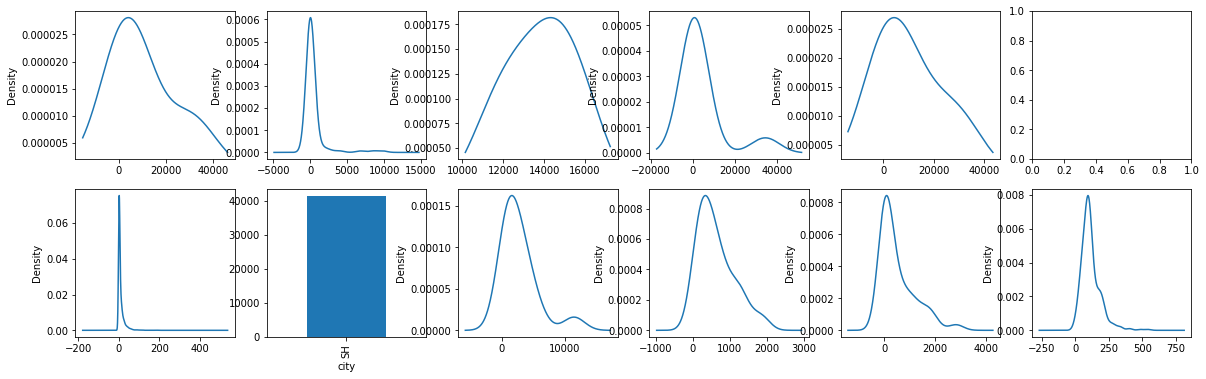

In [59]:
# 统计分类变量频数
rentType = data_train.groupby([categorical[0]])[categorical[0]].count()
houseType = data_train.groupby('houseType')['houseType'].count()
houseFloor = data_train.groupby('houseFloor')['houseFloor'].count()
houseToward = data_train.groupby('houseToward')['houseToward'].count()
houseDecoration = data_train.groupby('houseDecoration')['houseDecoration'].count()
communityName = data_train.groupby('communityName')['communityName'].count()
city = data_train.groupby('city')['city'].count()
region = data_train.groupby('region')['region'].count()
plate = data_train.groupby('plate')['plate'].count()
buildYear = data_train.groupby('buildYear')['buildYear'].count()
tradeTime = data_train.groupby('tradeTime')['tradeTime'].count()

# 查看各频数分布
fig,axes = plt.subplots(2,6,figsize=(20,6))
rentType.plot(kind = 'kde',ax = axes[0][0])
houseType.plot(kind = 'kde',ax = axes[0][1])
houseFloor.plot(kind = 'kde',ax = axes[0][2])
houseToward.plot(kind = 'kde',ax = axes[0][3])
houseDecoration.plot(kind = 'kde',ax = axes[0][4])
communityName.plot(kind = 'kde',ax = axes[1][0])
city.plot(kind = 'bar',ax = axes[1][1])
region.plot(kind = 'kde',ax = axes[1][2])
plate.plot(kind = 'kde',ax = axes[1][3])
buildYear.plot(kind = 'kde',ax = axes[1][4])
tradeTime.plot(kind = 'kde',ax = axes[1][5])